In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from nilearn.plotting import plot_design_matrix
import statsmodels.api as sm

sys.path.append('/Users/jeanettemumford/Dropbox/Research/Projects/design_and_analysis/code_in_progress')

from utils import (calc_expected_run_num_by_chance, sample_shifted_truncated_exponential, 
                   est_eff_and_vif, est_psych_fitness, run_eff_sim)

## Spatial cueing task

We're still ironing out the details of the model, but I believe the task layout is correct.

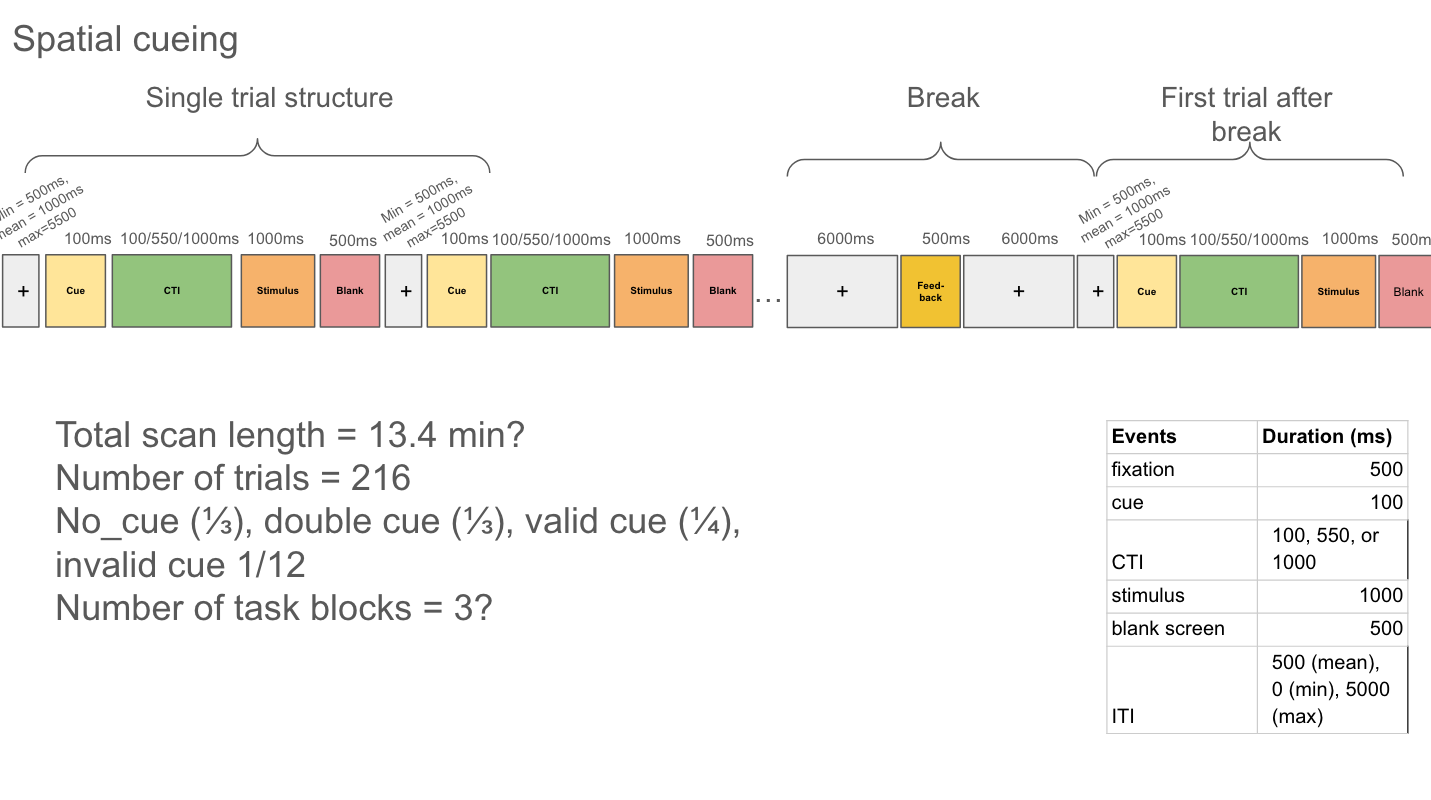

In [31]:
def make_spatial_cueing_timings(n_no_cue, n_double_cue, n_valid_cue, n_invalid_cue, cue_dur, cti_durs, stim_dur, blank_dur,  
                             nbreaks, break_fix_pre_message_dur, break_message_dur,  
                             break_fix_post_message_dur, isi_exp_lam, isi_truncation, 
                             isi_shift):
    '''
    Produces a randomly ordered set of trials for the spatial cueing task.
    Assumes a break between blocks of task.  Number of no_cue/double_cue/valid_cue trials will be equal
    for each block of the task 
    ISI is sampled from a truncated exponential.  Note the truncation value for the
    truncated exponential does *not* include the shift, so the max isi is
    isi_truncation + isi_shift.
    A trial is structured as:
      fixation (based on truncated exponential) + 
      cue(cue_dur) + CTI (3 values for duration) + stimulus (stim_dur) + blank (blank_dur) + 
      next trial (same structure as above until end of block is reached)
      At end of block the break begins with:
      fixation (length=break_dur) + 
      break message (break_message_dur) + 
      post message fixation (post_message_dur)
    Input:
      n_no_cue, n_double_cue, n_valid_cue: Total number of no_cue/double_cue/valid_cue trials 
          (will be evenly split between blocks) Integer divisible by (nbreaks + 1)
      cue_dur/cti_dur/stim_dur/blank_dur: Durations of cue/cti/stim/blank.  
                                          All are integers, but cti, which is a vector of 3 values
      break_fix_pre_message_dur: Fixation duration at beginning of break (no jittering)
      break_message_dur:  Duration of message shown during break
      break_fix_post_message_dur:  Fixation duration after message (no jittering)
      isi_exp_lam:  (seconds) The lambda parameter of the exponential used for the isi 
                    (inverse is the non-truncated/non-shifted mean)
      isi_truncation: (seconds) Truncation value of the exponential *NOT* including shift.  
                      Max ISI = isi_truncation + isi_shift
      isi_shift: (seconds) Shift value for isi (minimum isi value)
    Output:
       Events pandas data frame with onsets, trial_type and duration.  
    '''
    
    nblocks = nbreaks + 1
    ntrials = n_no_cue + n_double_cue +  n_valid_cue + n_invalid_cue
    ntrials_per_block = int(ntrials/nblocks)
    n_no_cue_per_block = int(n_no_cue / (nblocks))
    n_double_cue_per_block = int(n_double_cue / (nblocks))
    n_valid_cue_per_block = int(n_valid_cue / (nblocks))     
    n_invalid_cue_per_block = int(n_invalid_cue / (nblocks))
    isi_vals, _ = sample_shifted_truncated_exponential(isi_exp_lam, isi_truncation, 
                                                    isi_shift, ntrials)

    # Each stimulus has 3 fragments and each break has 3 fragments
    isi_count = 0
    fragment_durations = []
    fragment_labels = []
    for cur_block in range(nblocks):
        cue_types = ['no_cue', 'double_cue', 'valid_cue', 'invalid_cue']
        cue_nums = [n_no_cue_per_block, n_double_cue_per_block, n_valid_cue_per_block, n_invalid_cue_per_block]
        stim_type_cti_val = []
        num_cti_vals = len(cti_durs)
        for cue_type, cue_num in zip(cue_types, cue_nums):
            for cti_dur in cti_durs:
                stim_type_cti_val.extend([[cue_type, cti_dur]]*int(cue_num/num_cti_vals))
        stim_type_cti_val_perm = np.random.permutation(np.array(stim_type_cti_val)) 
        for cur_trial in range(ntrials_per_block):
            cur_stim_type = stim_type_cti_val_perm[cur_trial,0]
            cur_cti_dur_s = float(stim_type_cti_val_perm[cur_trial,1])
            fragment_durations.extend([isi_vals[isi_count], cue_dur, cur_cti_dur_s, stim_dur, blank_dur])
            fragment_labels.extend(['isi_fix', f'cue_{cur_stim_type}', 'cti', f'stim_{cur_stim_type}_{int(1000*cur_cti_dur_s)}', 'blank'])
            isi_count = isi_count + 1
        #Add break
        fragment_durations.extend([break_fix_pre_message_dur, break_message_dur, break_fix_post_message_dur])
        fragment_labels.extend(['fix_break', 'break_message', 'fix_break'])

    # If you don't want the beginning of the run to start at 0, change this 
    # (e.g. if you want to add the 10s to reach steady state)
    run_start = 0
    fragment_onsets = np.cumsum([run_start] + fragment_durations)[:-1]       
    events_data = pd.DataFrame({'onset': fragment_onsets,
                                'trial_type': fragment_labels,
                                'duration': fragment_durations})
    events_data = events_data.loc[events_data['trial_type'].str.contains('cue|cti|stim|break_message')==True]
    return events_data

In [28]:
events_inputs = {
    'n_no_cue': 72,
    'n_double_cue': 72,
    'n_valid_cue': 54,
    'n_invalid_cue': 18,
    'cue_dur': .1,
    'cti_durs': [.4],
    'stim_dur': 1,
    'blank_dur': .5,
    'nbreaks': 2,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': .5
}

tr = 1.49
total_time = 13*60
contrasts = {'double_400-no_cue_400': 'stim_double_cue_400-stim_no_cue_400',
             'valid_400-double_400': 'stim_valid_cue_400-stim_double_cue_400',
             'invalid_400-double_400': 'stim_invalid_cue_400-stim_double_cue_400'
             }

In [17]:
trials_psych_assess_map = {'cue_no_cue': '1', 'cue_double_cue': '2', 'cue_valid_cue': '3', 'cue_invalid_cue': '4'}

ntrials = events_inputs['n_no_cue'] + events_inputs['n_double_cue'] +  events_inputs['n_valid_cue'] + events_inputs['n_invalid_cue']
unpermuted_trials = np.concatenate([np.repeat('1', int(events_inputs['n_no_cue']/3)), 
                                    np.repeat('2', int(events_inputs['n_double_cue']/3)),
                                    np.repeat('3', int(events_inputs['n_valid_cue']/3)),
                                    np.repeat('4', int(events_inputs['n_invalid_cue']/3))],
                                    axis=0)
avg_trial_repeats_info = calc_expected_run_num_by_chance(unpermuted_trials, nsims=5000)

for val in ['1', '2', '3', '4']:
    avg_trial_repeats_info[f'{val}_run_counts'] = avg_trial_repeats_info[f'{val}_run_counts'] * 3
print(avg_trial_repeats_info)

    run_length  1_run_counts  2_run_counts  3_run_counts  4_run_counts
0          1.0       32.3880       32.3496       30.6900       15.2808
1          2.0       10.8402       10.8516        7.7022        1.1532
2          3.0        3.4944        3.4848        1.7532        0.0600
3          4.0        1.0908        1.0872        0.3996        0.0024
4          5.0        0.3132        0.3204        0.0756        0.0000
5          6.0        0.0966        0.0954        0.0138        0.0000
6          7.0        0.0252        0.0288        0.0024        0.0000
7          8.0        0.0084        0.0066        0.0006        0.0000
8          9.0        0.0006        0.0024        0.0000        0.0000
9         10.0        0.0006        0.0012        0.0000        0.0000
10        11.0        0.0000        0.0000        0.0000        0.0000
11        12.0        0.0000        0.0000        0.0000        0.0000
12        13.0        0.0000        0.0000        0.0000        0.0000
13    

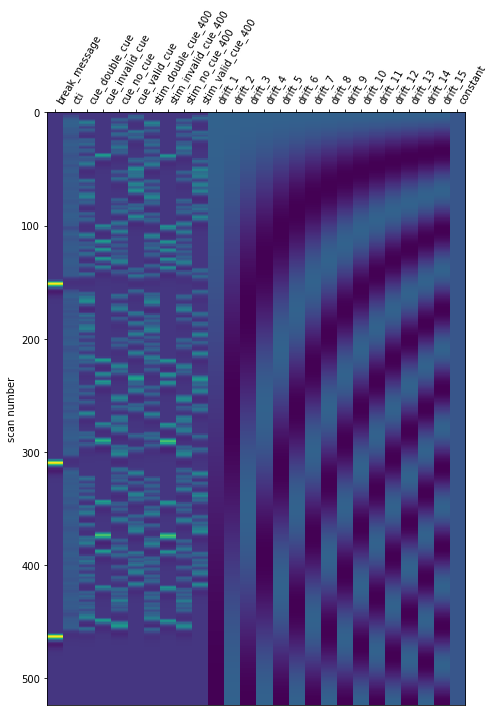

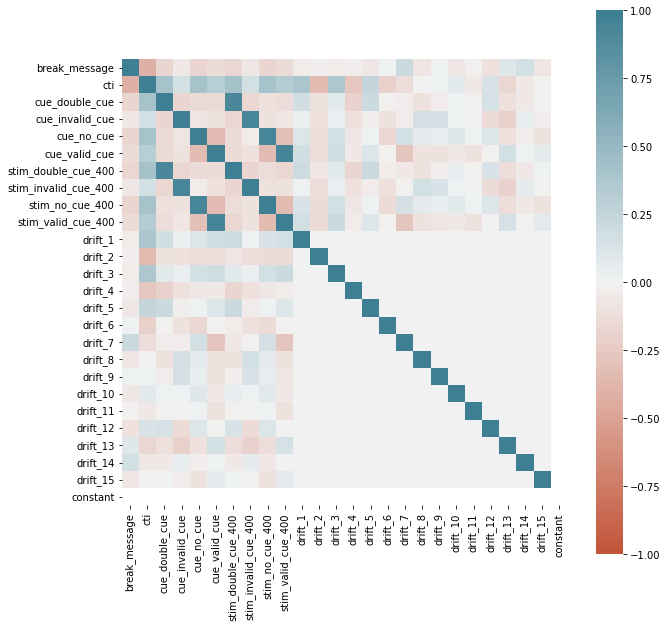

{'double_400-no_cue_400': 7.463975990303227, 'valid_400-double_400': 7.6677562625971705, 'invalid_400-double_400': 8.854859348710896}


In [33]:
events_ts = make_spatial_cueing_timings(**events_inputs)
eff, vif, desmat = est_eff_and_vif(events_ts, tr, total_time, contrasts, deriv=False)

plot_design_matrix(desmat)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    desmat.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
plt.show()

print(vif)

In [24]:
nsim = 250
output_setting1, events_setting1 = run_eff_sim(nsim, events_inputs, make_spatial_cueing_timings, 
                               contrasts, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map, deriv=False)

In [ ]:
g = sns.PairGrid(output_setting1)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.savefig('/Users/jeanettemumford/Desktop/junk.pdf', format="pdf", bbox_inches="tight")

In [26]:
pd.set_option('display.width', 1000)
summary_names = [f'eff_{name}' for name in contrasts.keys()] + \
                [f'vif_{name}' for name in contrasts.keys()] + \
                ['scan_length']

eff_vif_summaries_gng = {}
eff_vif_summaries_gng['setting1']= np.round(output_setting1[summary_names].quantile(q=[.05, .5, .95]), 2)

for key, val in eff_vif_summaries_gng.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_double_400-no_cue_400  eff_valid_400-double_400  eff_invalid_400-double_400  vif_double_400-no_cue_400  vif_valid_400-double_400  vif_invalid_400-double_400  scan_length
0.05                       0.42                      0.36                        0.17                       7.53                      7.77                        7.69       698.53
0.50                       0.46                      0.40                        0.19                       9.04                      9.00                        8.82       709.68
0.95                       0.51                      0.44                        0.20                      10.63                     10.99                       10.64       721.36
